# Ghostbuster Demo
In this notebook, we demonstrate the end-to-end Ghostbuster algorithm which reconstructs the 3D particle from the aberrated 2D particle stack. Ghostbuster essentially performs phase retrieval via RAF first to recover the complex-valued exitwaves, and subsequently uses DOFS to reconstruct the 3D particle.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from ghostbuster.ghostbuster import Ghostbuster

%load_ext autoreload
%autoreload 2

## Helper Functions

In [2]:
def plot_slices(arr, start_idx=0, end_idx=None, ylabel=None):
    sz = len(arr)
    if end_idx is not None:
        indices = np.linspace(start_idx, end_idx, 5).astype(int)
    else:
        indices = np.linspace(start_idx, sz - 1, 5).astype(int)
    fig, axes = plt.subplots(1, 5, constrained_layout=True, dpi=200)
    [ax.set(xticks=[], yticks=[]) for ax in axes.ravel()]
    for i, ind in enumerate(indices):
        ax = axes[i]
        ax.imshow(arr[ind])
        ax.set_title(f"slice {ind}")
    if ylabel is not None:
        axes[0].set_ylabel(ylabel)
    plt.show()

In [3]:
fft2 = lambda array: torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(array)))
ifft2 = lambda array: torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(array)))
ifftn = lambda array: torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(array)))
fftn = lambda array: torch.fft.fftshift(torch.fft.fftn(torch.fft.ifftshift(array)))

------
# Ghostbuster
we'll use Dataset D which contains 3500 real-valued particle intensities simulated with multislice. These particles are aberrated with defocus and spherical aberrations, and also contains ice and Poisson noise.

As explained in the RAF and DOFS demo notebooks, RAF is implemented on the CPU, whereas DOFS is implemented on the GPU due to memory constraints.

The overall time taken to complete 50 RAF iterations and 5000 Ghostbuster iterations was approximately 2.5-3 hours on our machine with NVIDIA L40 GPUs and 128 AMD EPYC 7736 64-Core Processors.

In [4]:
Nuse = 3500
D_intensities = torch.load("../datasets/datasetD-5MAC_3500_icy_particles_256x256.pt")[:Nuse]
D_quaternions = torch.load("../datasets/datasetD-quaternions.pt")[:Nuse]
D_defocuses = torch.load("../datasets/datasetD-effectivedefocuses.pt")[:Nuse]

In [5]:
groundtruth = torch.load("../datasets/5MAC_groundtruth.pt")

In [6]:
dx = 1  # [A]
wavelength = 0.02507847  # [A], for 200keV electron wave

In [7]:
ghostbuster = Ghostbuster(
    D_intensities,
    D_quaternions,
    D_defocuses,
    wavelength,
    pixelsize=dx,
    raf_device="cpu",
    dofs_device="cuda:1",
    alpha=0.1,
    dose=20,
    cs=2,
    dofs_batchsize=10,
)

In [8]:
ghostbuster.ghostbusting(
    raf_niter=50,
    dofs_niter=5000,
    groundtruth=groundtruth,
    dofs_stepsize=1,
    raf_stepsize=1,
    dofs_amplitude_contrast=True,
    dofs_positivity=True,
    mask_size=200,
)

Begin RAF.
Initializing volume via Pseudoinverse.
Creating vignette masks.
Vignette masks creation completed.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [48:20<00:00, 58.01s/it]


Normalizing RAF exitwaves


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3500/3500 [00:09<00:00, 371.34it/s]


Begin DOFS


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:50:02<00:00,  1.32s/it]


Done!


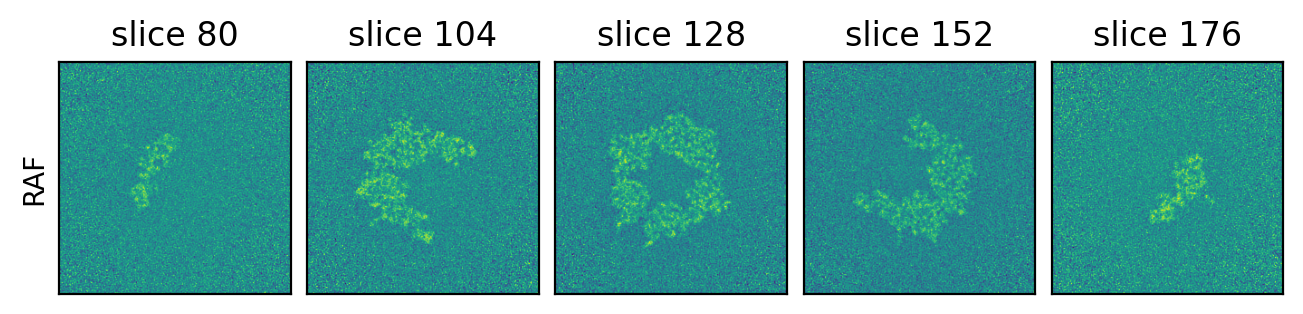

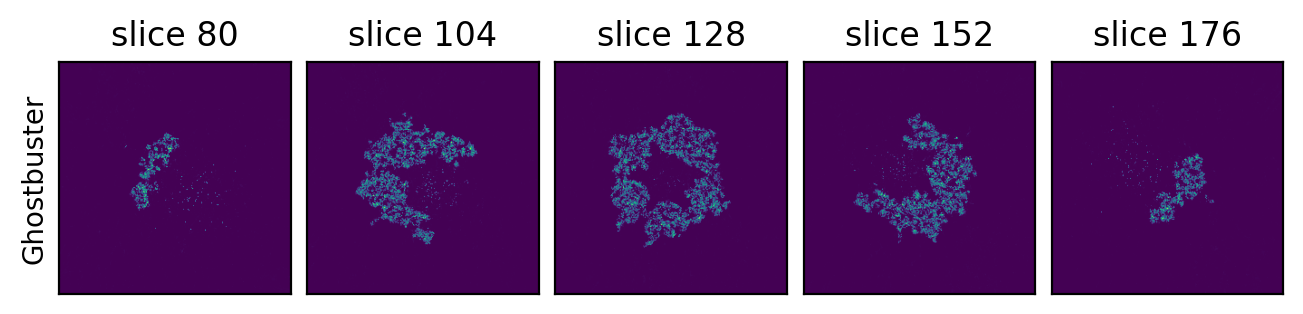

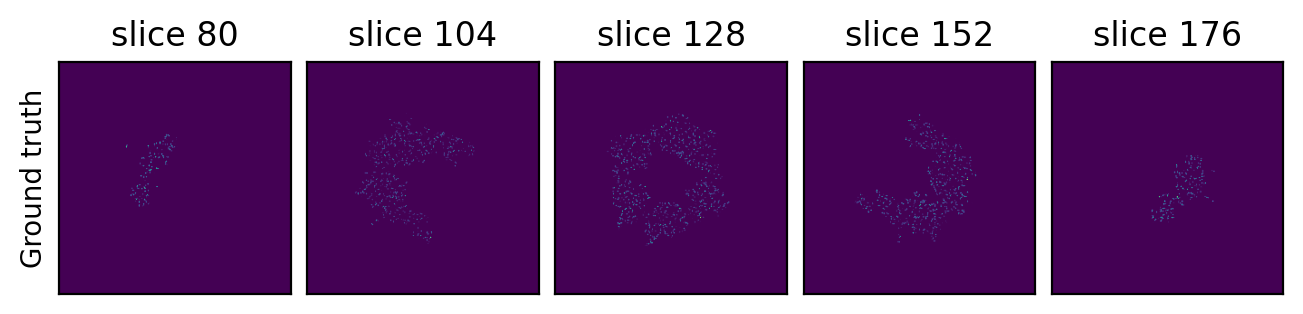

In [9]:
plot_slices(ghostbuster.surrogate_volume.cpu().imag, start_idx=80, end_idx=256 - 80, ylabel='RAF')
plot_slices(ghostbuster.reconstructed_particle.cpu().real, start_idx=80, end_idx=256 - 80, ylabel='Ghostbuster')
plot_slices(groundtruth.real, start_idx=80, end_idx=256 - 80, ylabel='Ground truth')